# Comparing Networks

In this notebook, we want to compare different network to each other.
This one focuses on...

- Trained Model (**Simple Gradient Ascent Unlearning**)*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ Simple Gradient Ascent: For every sample that we want to unlearn, we will take a step "up the loss function" in the training loop.

### ! Make sure that Trained, Exact, Untrained Model types are trained !

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet

from helper import load_models_dict

USED_DATASET = "cmnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = False# <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= True,
    test = False,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'


906

In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [3]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [4]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [5]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Simple Gradient Ascent Model


In [6]:
from unlearning import unlearn_n_models, SimpleGradientAscent
from training import save_model
from torch.utils.data import DataLoader

In [7]:
unlearned_dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8, # Hyperparameter: Same values as during training
    shuffle=False,
)

In [8]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = SimpleGradientAscent(
        model=trained_showcase_all,
        unlearned_data=unlearned_dataloader,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn()
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}{name}_mu_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [9]:

if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_dataloader,
        dataset_name=USED_DATASET,
        which_unlearning="SimpleGradientAscent",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble")

Unlearning 30 models trained on cmnist


Unlearned model  1/30...


Unlearned model  2/30...


Unlearned model  3/30...


Unlearned model  4/30...


Unlearned model  5/30...


Unlearned model  6/30...


Unlearned model  7/30...


Unlearned model  8/30...


Unlearned model  9/30...


Unlearned model 10/30...


Unlearned model 11/30...


Unlearned model 12/30...


Unlearned model 13/30...


Unlearned model 14/30...


Unlearned model 15/30...


Unlearned model 16/30...


Unlearned model 17/30...


Unlearned model 18/30...


Unlearned model 19/30...


Unlearned model 20/30...


Unlearned model 21/30...


Unlearned model 22/30...


Unlearned model 23/30...


Unlearned model 24/30...


Unlearned model 25/30...


Unlearned model 26/30...


Unlearned model 27/30...


Unlearned model 28/30...


Unlearned model 29/30...


Unlearned model 30/30...


___
### Exact Model

In [10]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    exact_showcase = TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    exact_showcase = ConvNet()
name = str(exact_showcase)
exact_showcase.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
        weights_only=True
        )
    )

<All keys matched successfully>

In [11]:
exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [12]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Untrained to ...

In [13]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

36.37851738979419

In [14]:
# ...unlearned model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

38.49911596973737

In [15]:
# ...exact model
a13 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a13

36.80754758268595

#### Trained to ...

In [16]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

10.217634074017406

In [17]:
# ...exact model
a22 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a22

38.481178574760754

#### GA to...

In [18]:
# ...exact model
a31 = calc_mutlimodel_metric_average(mu_ms, exact_ms, metric="l2_norm")
a31

40.0833835547169

#### Exact to ...

In [19]:
# see above

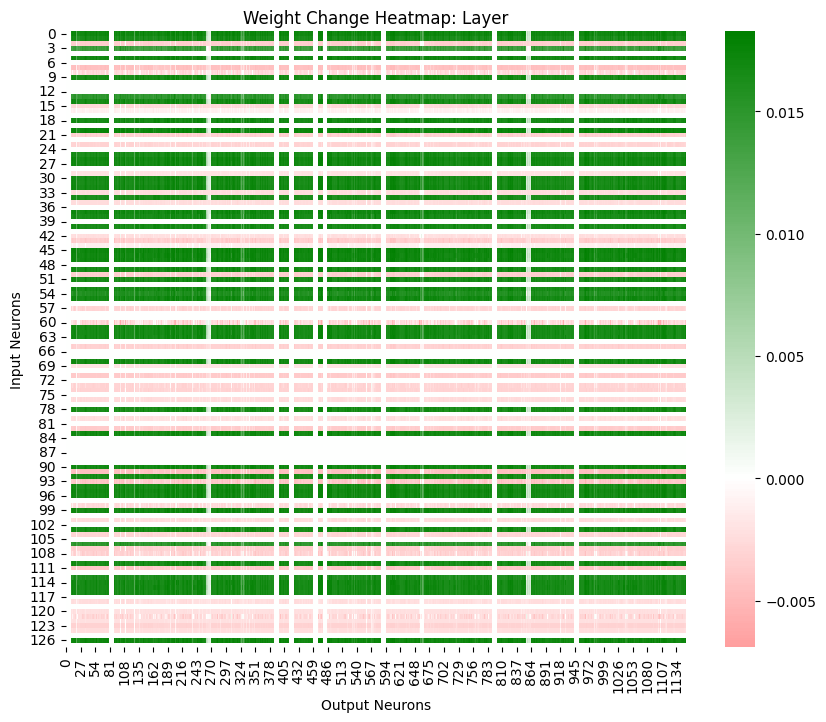

In [20]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[1].fc1.weight, weights_after=mu_ms[1].fc1.weight)

### Layer-wise Distance

In [21]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), mu_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'conv1.weight': 10.991098753611247,
 'conv1.bias': 0.4175111015637716,
 'conv2.weight': 265.31388804117836,
 'conv2.bias': 0.9678024590015412,
 'conv3.weight': 970.1277180989583,
 'conv3.bias': 1.64927632411321,
 'fc1.weight': 738.6930786132813,
 'fc1.bias': 0.564596504966418,
 'fc2.weight': 2.6265857060750326,
 'fc2.bias': 0.038531783347328506}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [22]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.970890448351352

In [24]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.0701704833939756

In [25]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.30760728239316

#### Trained to...

In [26]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

6.013443189754822

In [27]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.10972575388800448

In [28]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

6.100773125294356

#### Exact to ...

In [29]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

7.536597666824074

In [30]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.15252011064358317

In [31]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

8.298015472972603

#### MU to...

In [32]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

10.138499714477717

In [33]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

12.769638948691519

In [34]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

12.976192789189305

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [35]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.0981 - Standard Deviation for D_gesamt: 0.0037


Average Accuracy for D_remain: 0.1093 - Standard Deviation for D_remain: 0.0041


Average Accuracy for 0: 0.0000 - Standard Deviation for 0: 0.0000


Average Accuracy for 1: 0.0000 - Standard Deviation for 1: 0.0000


Average Accuracy for 2: 0.0000 - Standard Deviation for 2: 0.0000


Average Accuracy for 3: 0.2000 - Standard Deviation for 3: 0.4000


Average Accuracy for 4: 0.0000 - Standard Deviation for 4: 0.0000


Average Accuracy for 5: 0.0333 - Standard Deviation for 5: 0.1795


Average Accuracy for 6: 0.0000 - Standard Deviation for 6: 0.0000


Average Accuracy for 8: 0.3000 - Standard Deviation for 8: 0.4583


Average Accuracy for 9: 0.4667 - Standard Deviation for 9: 0.4989


Average Accuracy for 7_all: 0.0000 - Standard Deviation for 7_all: 0.0000


Average Accuracy for 7_remain: 0.0000 - Standard Deviation for 7_remain: 0.0000


Average Accuracy for 7_erased: 0.0000 - Standard Deviation for 7_erased: 0.0000
plotting...


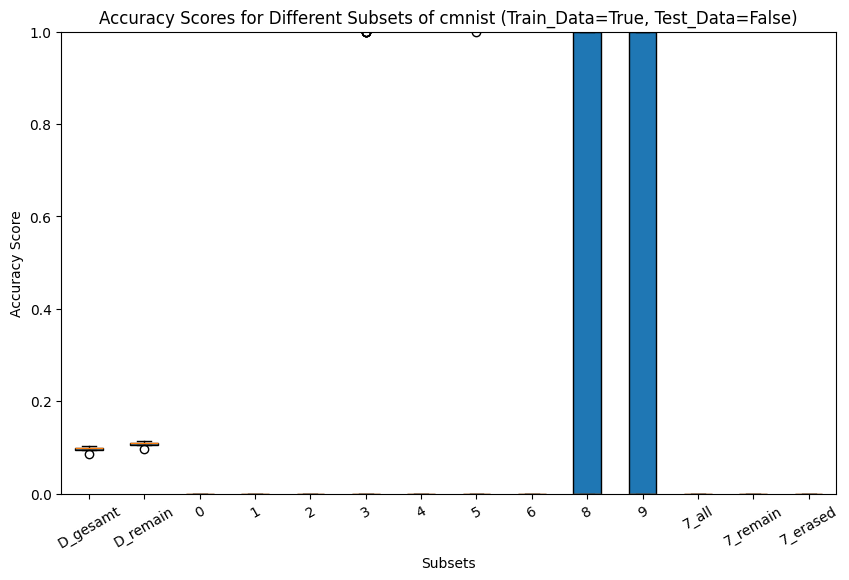

In [36]:
accs["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.0995 - Standard Deviation for D_gesamt: 0.0025


Average Accuracy for D_remain: 0.1104 - Standard Deviation for D_remain: 0.0028


Average Accuracy for 0: 0.0000 - Standard Deviation for 0: 0.0000


Average Accuracy for 1: 0.0000 - Standard Deviation for 1: 0.0000


Average Accuracy for 2: 0.0000 - Standard Deviation for 2: 0.0000


Average Accuracy for 3: 0.2000 - Standard Deviation for 3: 0.4000


Average Accuracy for 4: 0.0000 - Standard Deviation for 4: 0.0000


Average Accuracy for 5: 0.0333 - Standard Deviation for 5: 0.1795


Average Accuracy for 6: 0.0000 - Standard Deviation for 6: 0.0000


Average Accuracy for 8: 0.3000 - Standard Deviation for 8: 0.4583


Average Accuracy for 9: 0.4667 - Standard Deviation for 9: 0.4989


Average Accuracy for 7_all: 0.0000 - Standard Deviation for 7_all: 0.0000


Average Accuracy for 7_remain: 0.0000 - Standard Deviation for 7_remain: 0.0000


Average Accuracy for 7_erased: 0.0000 - Standard Deviation for 7_erased: 0.0000
plotting...


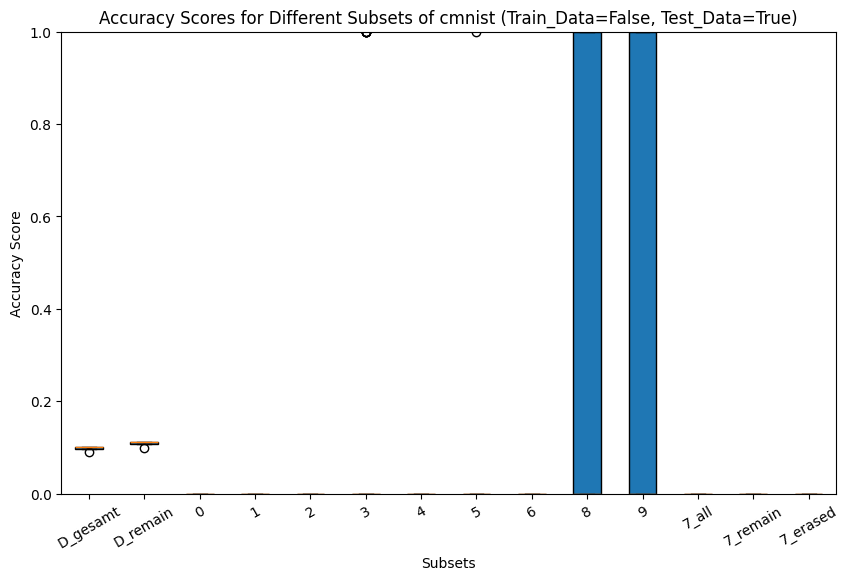

In [37]:
accs["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [38]:
losses = {}

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 246.8622 - Standard Deviation for D_gesamt: 40.8838


Average Loss for D_remain: 213.9987 - Standard Deviation for D_remain: 37.4955


Average Loss for 0: 263.4065 - Standard Deviation for 0: 67.5377


Average Loss for 1: 214.9965 - Standard Deviation for 1: 54.2382


Average Loss for 2: 233.6591 - Standard Deviation for 2: 61.3459


Average Loss for 3: 189.1304 - Standard Deviation for 3: 105.5271


Average Loss for 4: 242.1177 - Standard Deviation for 4: 53.5409


Average Loss for 5: 221.5608 - Standard Deviation for 5: 59.7555


Average Loss for 6: 233.3605 - Standard Deviation for 6: 62.6654


Average Loss for 8: 175.6995 - Standard Deviation for 8: 128.7760


Average Loss for 9: 143.1351 - Standard Deviation for 9: 138.6054


Average Loss for 7_all: 537.2806 - Standard Deviation for 7_all: 83.8676


Average Loss for 7_remain: 614.1218 - Standard Deviation for 7_remain: 95.8493


Average Loss for 7_erased: 538.6749 - Standard Deviation for 7_erased: 84.0885
plotting...


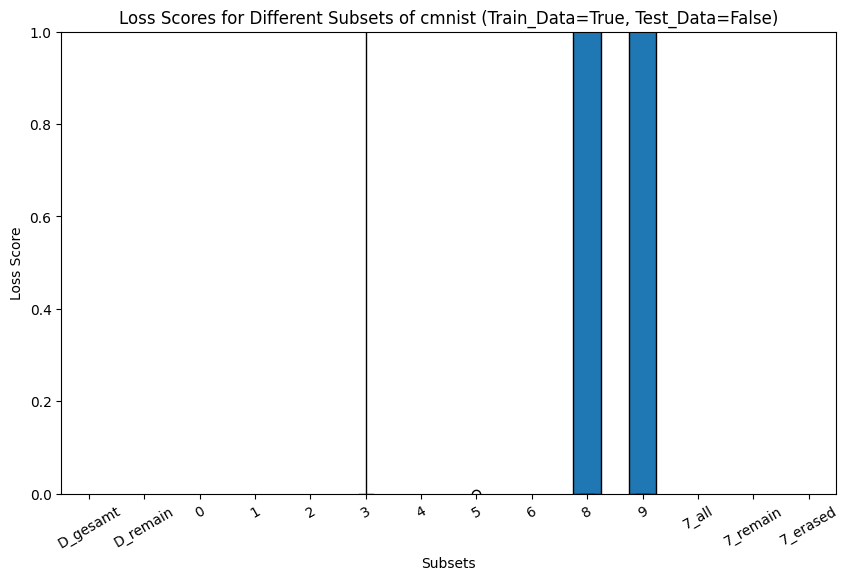

In [39]:
losses["mu_ms_train"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 244.8917 - Standard Deviation for D_gesamt: 40.6718


Average Loss for D_remain: 213.5788 - Standard Deviation for D_remain: 37.4757


Average Loss for 0: 261.7428 - Standard Deviation for 0: 67.0897


Average Loss for 1: 212.8123 - Standard Deviation for 1: 53.6957


Average Loss for 2: 232.8081 - Standard Deviation for 2: 61.0822


Average Loss for 3: 189.4525 - Standard Deviation for 3: 105.6919


Average Loss for 4: 241.1819 - Standard Deviation for 4: 53.3571


Average Loss for 5: 223.5314 - Standard Deviation for 5: 60.2705


Average Loss for 6: 235.2862 - Standard Deviation for 6: 63.1804


Average Loss for 8: 175.8286 - Standard Deviation for 8: 128.8697


Average Loss for 9: 143.7929 - Standard Deviation for 9: 139.2388


Average Loss for 7_all: 534.0188 - Standard Deviation for 7_all: 83.3691


Average Loss for 7_remain: 633.8063 - Standard Deviation for 7_remain: 99.3462


Average Loss for 7_erased: 534.0717 - Standard Deviation for 7_erased: 83.3655
plotting...


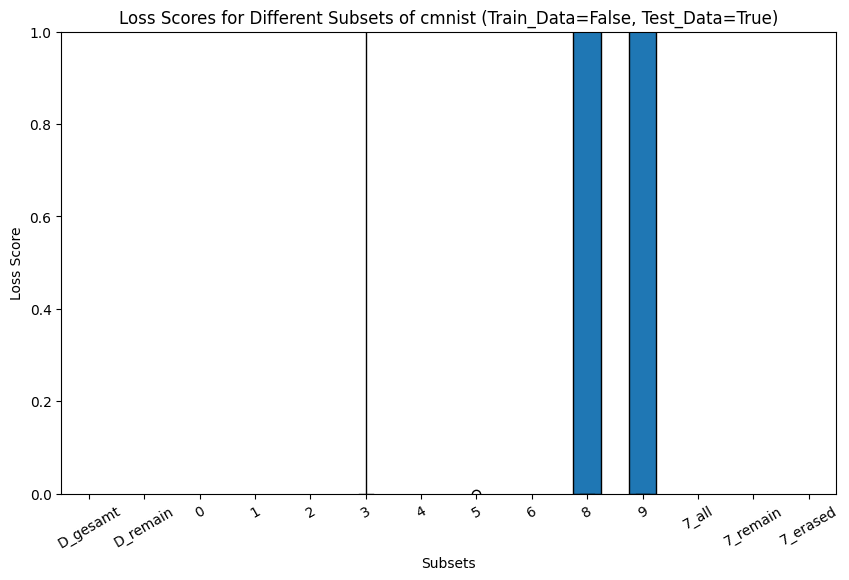

In [40]:
losses["mu_ms_test"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)